# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

Team Members:

Stylianos Sidiropoulos (stysi607)

Vasileia Kampouraki (vaska979)

# Part 1: Get the data

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on.

Question 1: What graphics card is available in the cloud machine? Run 'nvidia-smi' in the terminal.

Answer 1: According to the command output, the available graphics card is a Tesla K80.

Question 2: Google the name of the graphics card, how many CUDA cores does it have?

Answer 2: According to the official NVIDIA (https://www.nvidia.com/en-gb/data-center/tesla-k80/) website it has 4992 CUDA cores.

Question 3: How much memory does the graphics card have?

Answer 3: According to the command output, Tesla K80 has 11441MB of memory.

Question 4: What is stored in the GPU memory while training a DNN ?

Answer 4: While training a DNN, large amounts of weights (plus biases) and activations are stored in the GPU memory. In addition, the current batch of data and gradients for all trainable parameters is stored in the GPU memory.

Question 5: What CPU is available in the cloud machine? How many cores does it have? Run 'lscpu' in the terminal.

Answer 5: According to the command output, the cloud machine has an Intel Xeon CPU E5-2690 v3 @ 2.60GHz and it has 6 cores.

Question 6: How much CPU memory (RAM) is available in the cloud machine? Run 'free -g' in the terminal.

Answer 6: According to the command output, the available memory is 53 GB out of 55GB ('g' in 'free -g' stands for GB)

# Part 4: Load the data

Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. 

We will use the function `genfromtxt` to load the data.

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.




In [2]:
from numpy import genfromtxt
import numpy as np

In [3]:
# Load data from file
# X = covariates, Y = labels
X = genfromtxt("Mirai_dataset.csv", delimiter=",")
Y = genfromtxt("Mirai_labels.csv", delimiter=",")

# Save data as numpy arrays, for faster loading in future calls to this cell
np.save('Mirai_data.npy', X)
np.save('Mirai_labels.npy', Y)

In [4]:
# Load data from numpy arrays, for faster loading
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

# Remove the first 24 covariates
X = np.delete(X, obj=np.s_[:24], axis=1)
# X= X[:,24:116]

print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class
print('Class 0 has {} examples'.format(sum([1 for i in Y if i==0])))
print('Class 1 has {} examples'.format(sum([1 for i in Y if i==1])))

The covariates have size (764137, 92).
The labels have size (764137,).
Class 0 has 121621 examples
Class 1 has 642516 examples


# Part 5: How good is a naive classifier?

Question 7: Given the distribution of examples, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by random chance.

Answer 7: Assuming that all examples belong to one class (the majority class in the training set), the naive classifier have higher accuracy in this case, compared with other naive classifier assumptions. 

The accuracy is given by the propabilistic model:
P(yhat=y)= P(yhat = 0) * P(y = 0) + P(yhat = 1) * P(y = 1), 
where yhat is the prediction and it's a binary variable(0 or 1) representing the classes.
Since the classifier will assume that all examples belong to one class, if the class assumed is class 0 the accuracy will be around 16% whereas if the assumed class is 1 the accuracy will be around 84%. (Check code chunk below)

In [5]:
#https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/
# Distribution of the examples:
print('Class 0: %.3f' % ((sum([1 for i in Y if i==0]))/ len(Y) * 100))
print('Class 1: %.3f' % ((sum([1 for i in Y if i==1])) / len(Y) * 100))

Class 0: 15.916
Class 1: 84.084


In [6]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()
print(np.isnan(X))
print(np.isnan(Y))

# Print the number of NaNs (not a number) in the labels
print('Labels have {} NaNs'.format(np.sum(np.isnan(Y))))

# Print the number of NaNs in the covariates
print('Covariates have {} NaNs'.format(np.sum(np.isnan(X))))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[False False False ... False False False]
Labels have 0 NaNs
Covariates have 0 NaNs


# Part 6: Preprocessing

Lets do some simple preprocessing

In [7]:
# Convert covariates to floats
X = X.astype(float)

# Convert labels to ints
Y = Y.astype(int)

# Remove mean of each covariate (column)
X = X - np.mean(X, axis=0)

# Divide each covariate (column) by its standard deviation
X = X/np.std(X, axis=0)

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print("Mean")
print(np.mean(X, axis=0))
print("Standard Deviation")
print(np.std(X, axis=0))

Mean
[-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2.

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)


In [8]:
split = int(0.7*X.shape[0])
Xtrain = X[:split,:]
Xtemp = X[split:,:]
Ytrain = Y[:split,]
Ytemp = Y[split:,]

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print('Class 0 in Ytrain has {} examples'.format(sum([1 for i in Ytrain if i==0])))
print('Class 1 in Ytrain has {} examples'.format(sum([1 for i in Ytrain if i==1])))
print('Class 0 in Ytemp has {} examples'.format(sum([1 for i in Ytemp if i==0])))
print('Class 1 in Ytemp has {} examples'.format(sum([1 for i in Ytemp if i==1])))

Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
Class 0 in Ytrain has 121621 examples
Class 1 in Ytrain has 413274 examples
Class 0 in Ytemp has 0 examples
Class 1 in Ytemp has 229242 examples


# Part 8: Number of examples per class

Question 8: Can we use the dataset as it is? Why not?

Answer 8: No, we can't use it as it is, because the rows are not shuffled. We can't use the data as it is because we see that when we split the data, there are 0 examples of class0 in the remaining data and thus the results are not gonna be good as the data partition is not representative of the distribution of the data.

Lets randomly shuffle the data, to get some examples of each class in training data and in the remaining 30%. Use the function `shuffle` in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html

In [9]:
from sklearn.utils import shuffle

# Randomly shuffle data, to get both classes in training and testing
X, Y = shuffle(X, Y)

# Divide the data into training and validation/test again
split = int(0.7*X.shape[0])
Xtrain = X[:split,:]
Xtemp = X[split:,:]
Ytrain = Y[:split,]
Ytemp = Y[split:,]

#split2 =  int(0.5*Xtemp.shape[0])
#Xtest = Xtemp[:split2,:]
#Xvalid = Xtemp[split2:,:]
#Ytest = Ytemp[:split2,]
#Yvalid = Ytemp[split2:,]

# Print the number of examples of each class, for the training data and the remaining 30%
print('Class 0 in Ytrain has {} examples'.format(sum([1 for i in Ytrain if i==0])))
print('Class 1 in Ytrain has {} examples'.format(sum([1 for i in Ytrain if i==1])))
print('Class 0 in Ytemp has {} examples'.format(sum([1 for i in Ytemp if i==0])))
print('Class 1 in Ytemp has {} examples'.format(sum([1 for i in Ytemp if i==1])))
#print('Class 0 in Ytest has {} examples'.format(sum([1 for i in Ytest if i==0])))
#print('Class 1 in Ytest has {} examples'.format(sum([1 for i in Ytest if i==1])))
#print('Class 0 in Yvalid has {} examples'.format(sum([1 for i in Yvalid if i==0])))
#print('Class 1 in Yvalid has {} examples'.format(sum([1 for i in Yvalid if i==1])))

Class 0 in Ytrain has 85138 examples
Class 1 in Ytrain has 449757 examples
Class 0 in Ytemp has 36483 examples
Class 1 in Ytemp has 192759 examples


#  Part 9: Split non-training data data into validation and test
Split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [10]:
from sklearn.model_selection import train_test_split

Xtest, Xval, Ytest, Yval = train_test_split(Xtemp, Ytemp, test_size=0.5)

print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 10: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [11]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy as BC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer=='sgd':
        optim = SGD(lr=learning_rate)
    if optimizer=='adam':
        optim = Adam(learning_rate=learning_rate)
    
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    
    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_shape=input_shape))
    if use_bn == True:
        model.add(BatchNormalization())
    if use_dropout == True:
            model.add(Dropout(rate=0.5))
    if use_custom_dropout == True:
            model.add(myDropout(rate=0.5))
    
    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=act_fun))
        if use_bn == True:
            model.add(BatchNormalization())
        if use_dropout == True:
            model.add(Dropout(rate=0.5))
        if use_custom_dropout == True:
            model.add(myDropout(rate=0.5))
    # Final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss=BC, optimizer=optim, metrics=['accuracy'])
    
    return model

In [12]:
# Lets define a help function for plotting the training results

# IMPORTANT NOTE
# The history unfortunately behaves a bit randomly for every user
# If the plots for accuracy and loss look mixed, change the order of
# val_loss, val_acc, loss, acc
# until the plots look as they "should"

import matplotlib.pyplot as plt
def plot_results(history):
    val_loss, val_acc, loss, acc = history.history.values()

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 11: Train the DNN

Time to train the DNN, we start simple with 2 layers with 2 nodes each, learning rate 0.1.

### 2 layers, 20 nodes

In [13]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = (92,)

# Build the model
model1 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 9s - loss: 0.4478 - accuracy: 0.8276 - val_loss: 0.4039 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.3800 - accuracy: 0.8408 - val_loss: 0.3559 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.3288 - accuracy: 0.8408 - val_loss: 0.3020 - val_accuracy: 0.8400
Epoch 4/20
 - 1s - loss: 0.2771 - accuracy: 0.8408 - val_loss: 0.2548 - val_accuracy: 0.8400
Epoch 5/20
 - 1s - loss: 0.2381 - accuracy: 0.8509 - val_loss: 0.2243 - val_accuracy: 0.8596
Epoch 6/20
 - 1s - loss: 0.2149 - accuracy: 0.8730 - val_loss: 0.2074 - val_accuracy: 0.8946
Epoch 7/20
 - 1s - loss: 0.2020 - accuracy: 0.9022 - val_loss: 0.1978 - val_accuracy: 0.9050
Epoch 8/20
 - 1s - loss: 0.1946 - accuracy: 0.9050 - val_loss: 0.1920 - val_accuracy: 0.9053
Epoch 9/20
 - 1s - loss: 0.1898 - accuracy: 0.9053 - val_loss: 0.1880 - val_accuracy: 0.9059
Epoch 10/20
 - 1s - loss: 0.1864 - accuracy: 0.9056 - val_loss: 0.1851 - val_accuracy: 0.9061
Epoch 11/20
 - 1s

In [14]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1708
Test accuracy: 0.9088


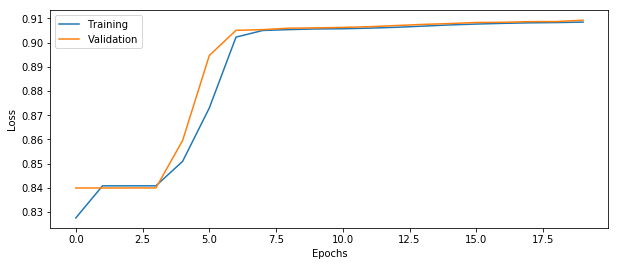

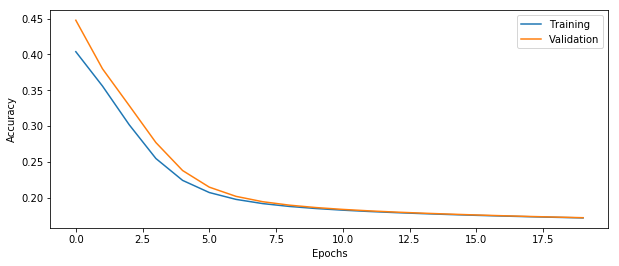

In [15]:
# Plot the history from the training run
plot_results(history1)

# Part 12: More questions

Question 9: What happens if you add several Dense layers without specifying the activation function?

Answer 9: If the activation function is not specified then the default setting is to apply linear activation, i.e. a(x)=x
which basicaly means no activation function is applied and then all dense layers can be replaced by a single dense layer.

Question 10: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

Answer 10: According to the Keras Core Layers documentation (https://keras.io/layers/core/), the weights are initialized by defualt using 'glorot_uniform' which draws samples from a uniform distribution within [-limit, limit] (https://keras.io/initializers/) and the default bias initializer is 'zeros'.

# Part 13: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [16]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(Ytrain), Ytrain)

# Print the class weights
print(class_weights)

[3.14134112 0.59464889]


### 2 layers, 20 nodes, class weights

In [17]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)

history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.4151 - accuracy: 0.8408 - val_loss: 0.3946 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.3713 - accuracy: 0.8408 - val_loss: 0.3472 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.3202 - accuracy: 0.8408 - val_loss: 0.2934 - val_accuracy: 0.8400
Epoch 4/20
 - 1s - loss: 0.2695 - accuracy: 0.8436 - val_loss: 0.2482 - val_accuracy: 0.8530
Epoch 5/20
 - 1s - loss: 0.2332 - accuracy: 0.8613 - val_loss: 0.2207 - val_accuracy: 0.8732
Epoch 6/20
 - 1s - loss: 0.2126 - accuracy: 0.8806 - val_loss: 0.2058 - val_accuracy: 0.8951
Epoch 7/20
 - 1s - loss: 0.2013 - accuracy: 0.9021 - val_loss: 0.1974 - val_accuracy: 0.9051
Epoch 8/20
 - 1s - loss: 0.1947 - accuracy: 0.9045 - val_loss: 0.1922 - val_accuracy: 0.9055
Epoch 9/20
 - 1s - loss: 0.1903 - accuracy: 0.9049 - val_loss: 0.1885 - val_accuracy: 0.9060
Epoch 10/20
 - 1s - loss: 0.1871 - accuracy: 0.9053 - val_loss: 0.1857 - val_accuracy: 0.9063
Epoch 11/20
 - 1s

In [18]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1715
Test accuracy: 0.9086


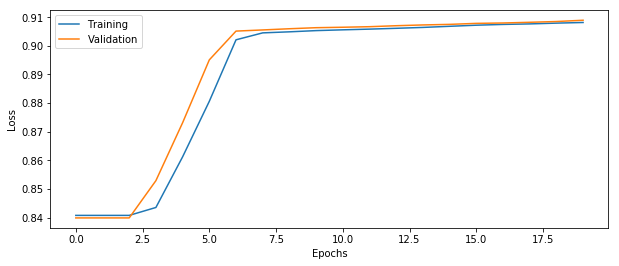

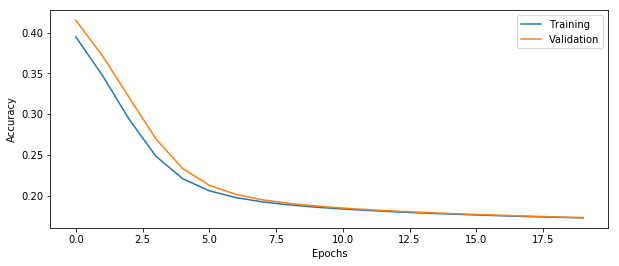

In [19]:
plot_results(history2)

# Part 14: More questions

Question 11: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

Answer 11: Due to the large amounts of the datasets (several GBs), we cannot fit all of the training set in the GPU memory. In that case, we need to split the data in batches and "feed" them to the memory.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the cloud computer a few times during training.

Answer 12: On average, about 30%

Question 13: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Answer 13: For 100 batches is 12 seconds, for 1000 batces is 2 seconds and for 10.000 batches is 1 second per epoch. This is because when the number of  batches is smaller the number of weights updates is bigger. Another aspect is that the GPU will not work 100% for small batch sizes (the 4992 cores want something to do), so for larger batch sizes the GPU comes closer to 100% utilization, which reduces training time.

Question 14: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

Answer 14: Our training samples are 534895.If we choose a batch size of 100 then 5348.95 weight updates will occur. If batch size=1000 we'll get 534.895 weight updates and 53.4895 weight updates for batch size=10.000. 

Question 15: What limits how large the batch size can be?

Answer 15: What limits the batch size is the total number of all training data we have. Batch size can't be larger than the total number of observations we have in our dataset. Generally  1<=batch size<= size of training data. We usually choose a quite small batch size when training DNNs because probably not all data will fit in the GPU memory and also a small batch size will give a regularization effect and consequently higher performance(however they are a bit noisy).

Question 16: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

Answer 16: The learning rate is analogous to the batch size. So, if the batch size is small then we also choose a quite small learning rate because the gradient is more uncertain and when the batch size is big we may use bigger learning rate because fewer weights will be updated.

(Theory based on teacher's slides)

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

In [20]:
# Question 13 code chunk
epochs = 3
input_shape = (92,)
batch_size = 100
model2 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1)
history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/3
 - 12s - loss: 0.1761 - accuracy: 0.9081 - val_loss: 0.1550 - val_accuracy: 0.9174
Epoch 2/3
 - 12s - loss: 0.1520 - accuracy: 0.9182 - val_loss: 0.1496 - val_accuracy: 0.9193
Epoch 3/3
 - 12s - loss: 0.1476 - accuracy: 0.9198 - val_loss: 0.1460 - val_accuracy: 0.9203


In [21]:
# Question 14 code chunk
batch_size = 1000
epochs=3
history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/3
 - 2s - loss: 0.1448 - accuracy: 0.9210 - val_loss: 0.1456 - val_accuracy: 0.9211
Epoch 2/3
 - 2s - loss: 0.1444 - accuracy: 0.9214 - val_loss: 0.1452 - val_accuracy: 0.9209
Epoch 3/3
 - 2s - loss: 0.1440 - accuracy: 0.9216 - val_loss: 0.1448 - val_accuracy: 0.9215


In [22]:
batch_size = 10000
epochs=3
history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/3
 - 1s - loss: 0.1437 - accuracy: 0.9221 - val_loss: 0.1447 - val_accuracy: 0.9215
Epoch 2/3
 - 1s - loss: 0.1436 - accuracy: 0.9220 - val_loss: 0.1447 - val_accuracy: 0.9214
Epoch 3/3
 - 1s - loss: 0.1436 - accuracy: 0.9220 - val_loss: 0.1447 - val_accuracy: 0.9215


# Part 15: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 17: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

Answer 17: Initial network with 2 layers, 20 nodes/layer have 2301 trainable parameters, whereas network with 4 layers, 50 nodes/layer has 12351 trainable parameters (See output below)

In [23]:
# 2 layers, 20 nodes
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 20)                1860      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 4 layers, 50 nodes
model_question17 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)
model_question17.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 50)                4650      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 12,351
Trainable params: 12,351
Non-trainable params: 0
_________________________________________________________________


### 4 layers, 20 nodes, class weights

In [25]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model3 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=20, learning_rate=0.1)

history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.4734 - accuracy: 0.8029 - val_loss: 0.4384 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.4368 - accuracy: 0.8408 - val_loss: 0.4381 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.4365 - accuracy: 0.8408 - val_loss: 0.4378 - val_accuracy: 0.8400
Epoch 4/20
 - 1s - loss: 0.4362 - accuracy: 0.8408 - val_loss: 0.4375 - val_accuracy: 0.8400
Epoch 5/20
 - 1s - loss: 0.4359 - accuracy: 0.8408 - val_loss: 0.4371 - val_accuracy: 0.8400
Epoch 6/20
 - 1s - loss: 0.4354 - accuracy: 0.8408 - val_loss: 0.4367 - val_accuracy: 0.8400
Epoch 7/20
 - 1s - loss: 0.4350 - accuracy: 0.8408 - val_loss: 0.4361 - val_accuracy: 0.8400
Epoch 8/20
 - 1s - loss: 0.4344 - accuracy: 0.8408 - val_loss: 0.4355 - val_accuracy: 0.8400
Epoch 9/20
 - 1s - loss: 0.4337 - accuracy: 0.8408 - val_loss: 0.4348 - val_accuracy: 0.8400
Epoch 10/20
 - 1s - loss: 0.4329 - accuracy: 0.8408 - val_loss: 0.4339 - val_accuracy: 0.8400
Epoch 11/20
 - 1s

In [26]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.3858
Test accuracy: 0.8418


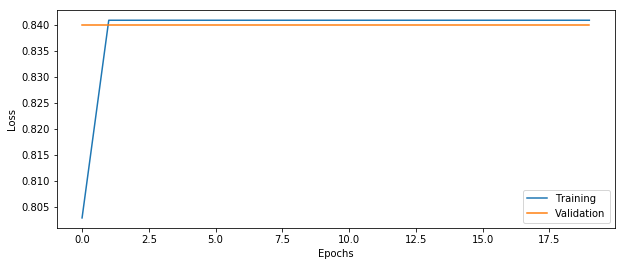

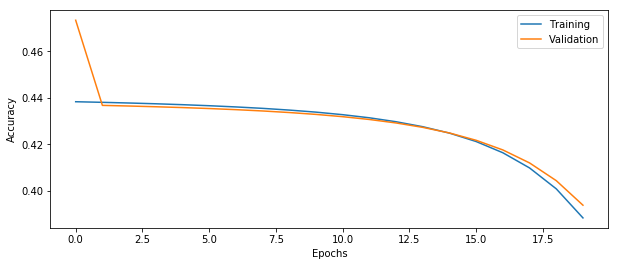

In [27]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [28]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model4 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=50, learning_rate=0.1)

history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.4170 - accuracy: 0.8408 - val_loss: 0.3832 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.3491 - accuracy: 0.8408 - val_loss: 0.3141 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.2813 - accuracy: 0.8439 - val_loss: 0.2528 - val_accuracy: 0.8525
Epoch 4/20
 - 1s - loss: 0.2340 - accuracy: 0.8601 - val_loss: 0.2195 - val_accuracy: 0.8796
Epoch 5/20
 - 1s - loss: 0.2108 - accuracy: 0.8861 - val_loss: 0.2041 - val_accuracy: 0.8949
Epoch 6/20
 - 1s - loss: 0.1997 - accuracy: 0.8979 - val_loss: 0.1960 - val_accuracy: 0.9011
Epoch 7/20
 - 1s - loss: 0.1935 - accuracy: 0.9025 - val_loss: 0.1911 - val_accuracy: 0.9049
Epoch 8/20
 - 1s - loss: 0.1894 - accuracy: 0.9054 - val_loss: 0.1876 - val_accuracy: 0.9065
Epoch 9/20
 - 1s - loss: 0.1863 - accuracy: 0.9063 - val_loss: 0.1848 - val_accuracy: 0.9071
Epoch 10/20
 - 1s - loss: 0.1838 - accuracy: 0.9066 - val_loss: 0.1826 - val_accuracy: 0.9075
Epoch 11/20
 - 1s

In [29]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1691
Test accuracy: 0.9092


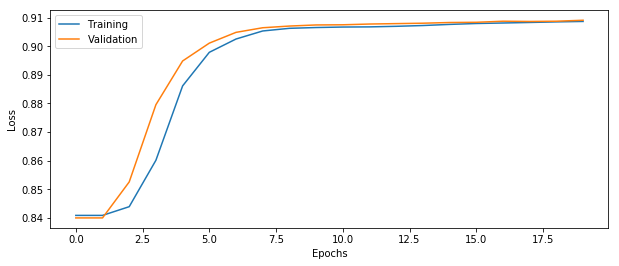

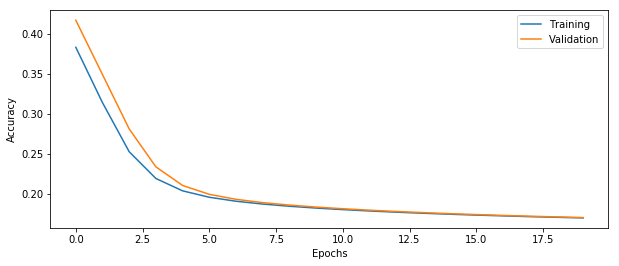

In [30]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [31]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model5 = build_DNN(input_shape=input_shape, n_layers=4, n_nodes=50, learning_rate=0.1)

history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.4457 - accuracy: 0.8408 - val_loss: 0.4397 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.4381 - accuracy: 0.8408 - val_loss: 0.4394 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.4379 - accuracy: 0.8408 - val_loss: 0.4392 - val_accuracy: 0.8400
Epoch 4/20
 - 1s - loss: 0.4376 - accuracy: 0.8408 - val_loss: 0.4389 - val_accuracy: 0.8400
Epoch 5/20
 - 1s - loss: 0.4374 - accuracy: 0.8408 - val_loss: 0.4387 - val_accuracy: 0.8400
Epoch 6/20
 - 1s - loss: 0.4371 - accuracy: 0.8408 - val_loss: 0.4384 - val_accuracy: 0.8400
Epoch 7/20
 - 1s - loss: 0.4368 - accuracy: 0.8408 - val_loss: 0.4381 - val_accuracy: 0.8400
Epoch 8/20
 - 1s - loss: 0.4365 - accuracy: 0.8408 - val_loss: 0.4377 - val_accuracy: 0.8400
Epoch 9/20
 - 1s - loss: 0.4361 - accuracy: 0.8408 - val_loss: 0.4374 - val_accuracy: 0.8400
Epoch 10/20
 - 1s - loss: 0.4357 - accuracy: 0.8408 - val_loss: 0.4370 - val_accuracy: 0.8400
Epoch 11/20
 - 1s

In [32]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.4216
Test accuracy: 0.8418


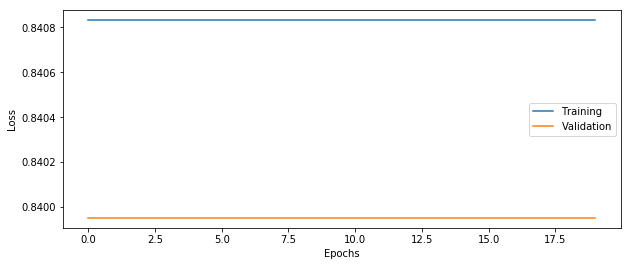

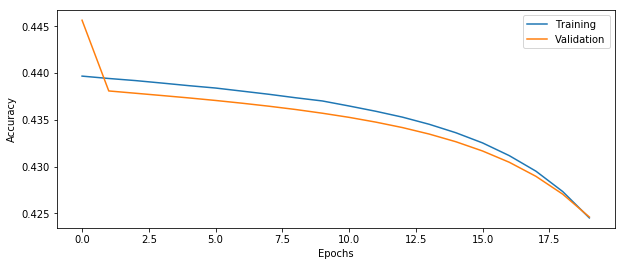

In [33]:
plot_results(history5)

# Part 16: Batch normalization

Now add batch normalization after each dense layer. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 18: Why is batch normalization important when training deep networks?

Answer 18: Batch normalization when training DNNs is important, because it improves the speed, performance and stability of the DNN. Each layer's input is normalized using the mean and standard deviation of the current batch. Batch normalization gives a higher test accuracy and the optimization is easier if all covariates have the same standard deviation.
(used some of the teacher's notes)

### 2 layers, 20 nodes, class weights, batch normalization

In [34]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model6 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_bn=True)

history6 = model6.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 2s - loss: 1.9919 - accuracy: 0.6188 - val_loss: 2.4541 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.8397
Epoch 3/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.8059
Epoch 4/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.7207
Epoch 5/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.5051
Epoch 6/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.4379
Epoch 7/20
 - 1s - loss: 2.4406 - accuracy: 0.3944 - val_loss: 2.4541 - val_accuracy: 0.4190
Epoch 8/20
 - 1s - loss: 2.4406 - accuracy: 0.3943 - val_loss: 2.4541 - val_accuracy: 0.4097
Epoch 9/20
 - 1s - loss: 2.4406 - accuracy: 0.3944 - val_loss: 2.4541 - val_accuracy: 0.4035
Epoch 10/20
 - 1s - loss: 2.4406 - accuracy: 0.3944 - val_loss: 2.4541 - val_accuracy: 0.4004
Epoch 11/20
 - 1s

In [35]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 2.4264
Test accuracy: 0.3929


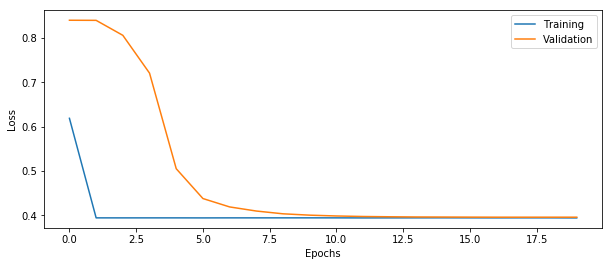

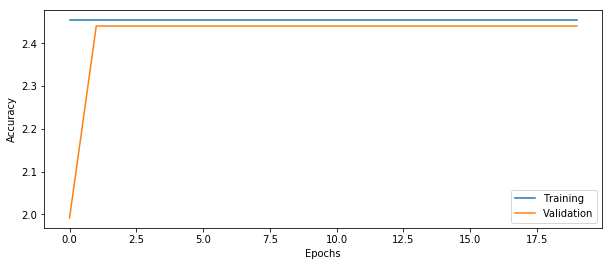

In [36]:
plot_results(history6)

# Part 17: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [37]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model7 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, act_fun='relu', learning_rate=0.1)

history7 = model7.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.2994 - accuracy: 0.8633 - val_loss: 0.1995 - val_accuracy: 0.8940
Epoch 2/20
 - 1s - loss: 0.1903 - accuracy: 0.8980 - val_loss: 0.1837 - val_accuracy: 0.9027
Epoch 3/20
 - 1s - loss: 0.1793 - accuracy: 0.9061 - val_loss: 0.1757 - val_accuracy: 0.9084
Epoch 4/20
 - 1s - loss: 0.1726 - accuracy: 0.9094 - val_loss: 0.1702 - val_accuracy: 0.9114
Epoch 5/20
 - 1s - loss: 0.1680 - accuracy: 0.9121 - val_loss: 0.1665 - val_accuracy: 0.9132
Epoch 6/20
 - 1s - loss: 0.1649 - accuracy: 0.9136 - val_loss: 0.1641 - val_accuracy: 0.9137
Epoch 7/20
 - 1s - loss: 0.1627 - accuracy: 0.9143 - val_loss: 0.1621 - val_accuracy: 0.9155
Epoch 8/20
 - 1s - loss: 0.1609 - accuracy: 0.9152 - val_loss: 0.1606 - val_accuracy: 0.9159
Epoch 9/20
 - 1s - loss: 0.1595 - accuracy: 0.9159 - val_loss: 0.1592 - val_accuracy: 0.9157
Epoch 10/20
 - 1s - loss: 0.1583 - accuracy: 0.9161 - val_loss: 0.1582 - val_accuracy: 0.9161
Epoch 11/20
 - 1s

In [38]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1515
Test accuracy: 0.9191


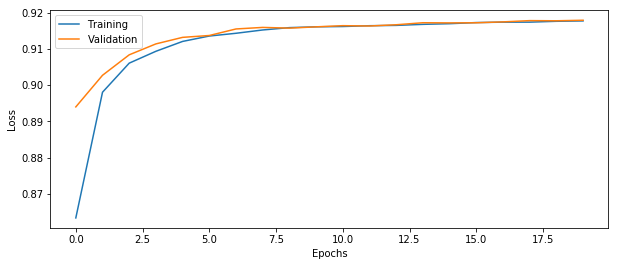

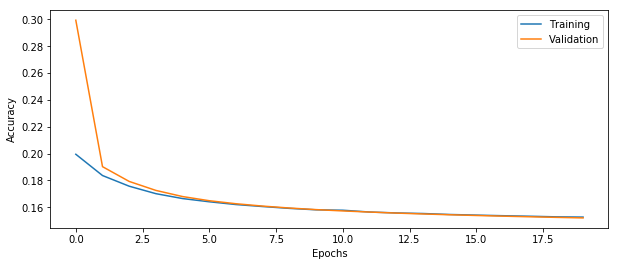

In [39]:
plot_results(history7)

# Part 18: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [40]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model8 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, optimizer='adam', learning_rate=0.1)

history8 = model8.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.2276 - accuracy: 0.8768 - val_loss: 0.1604 - val_accuracy: 0.9141
Epoch 2/20
 - 1s - loss: 0.1559 - accuracy: 0.9175 - val_loss: 0.1542 - val_accuracy: 0.9183
Epoch 3/20
 - 1s - loss: 0.1506 - accuracy: 0.9199 - val_loss: 0.1484 - val_accuracy: 0.9213
Epoch 4/20
 - 1s - loss: 0.1461 - accuracy: 0.9212 - val_loss: 0.1452 - val_accuracy: 0.9210
Epoch 5/20
 - 1s - loss: 0.1426 - accuracy: 0.9219 - val_loss: 0.1424 - val_accuracy: 0.9221
Epoch 6/20
 - 1s - loss: 0.1403 - accuracy: 0.9230 - val_loss: 0.1394 - val_accuracy: 0.9245
Epoch 7/20
 - 1s - loss: 0.1389 - accuracy: 0.9239 - val_loss: 0.1388 - val_accuracy: 0.9245
Epoch 8/20
 - 1s - loss: 0.1378 - accuracy: 0.9243 - val_loss: 0.1376 - val_accuracy: 0.9249
Epoch 9/20
 - 1s - loss: 0.1368 - accuracy: 0.9247 - val_loss: 0.1362 - val_accuracy: 0.9253
Epoch 10/20
 - 1s - loss: 0.1355 - accuracy: 0.9254 - val_loss: 0.1378 - val_accuracy: 0.9245
Epoch 11/20
 - 1s

In [41]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1224
Test accuracy: 0.9309


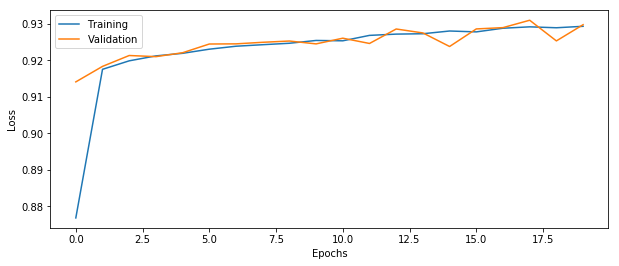

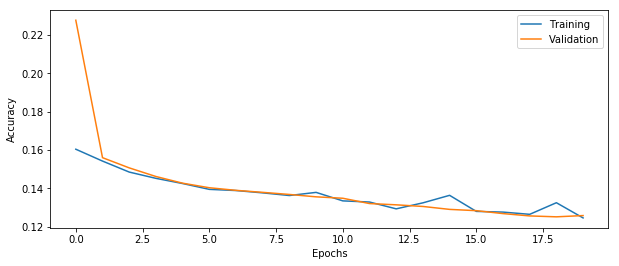

In [42]:
plot_results(history8)

# Part 19: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. 

Add a Dropout layer after each Dense layer (but not after the final dense layer), with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/layers/core/ for how the Dropout layer works.

---

Question 19: How does the validation accuracy change when adding dropout?

Answer 19: Validation accuracy when using dropout is lower than the one when we don't add dropout.

Question 20: How does the test accuracy change when adding dropout?

Answer 20: Test accuracy when using dropout is lower than the one when we don't add dropout, too.

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [43]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = (92,)

# Build and train model
model9 = build_DNN(input_shape=input_shape, n_layers=2, n_nodes=20, learning_rate=0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/20
 - 1s - loss: 0.5101 - accuracy: 0.7817 - val_loss: 0.4106 - val_accuracy: 0.8400
Epoch 2/20
 - 1s - loss: 0.4272 - accuracy: 0.8407 - val_loss: 0.3883 - val_accuracy: 0.8400
Epoch 3/20
 - 1s - loss: 0.4041 - accuracy: 0.8408 - val_loss: 0.3649 - val_accuracy: 0.8400
Epoch 4/20
 - 1s - loss: 0.3819 - accuracy: 0.8409 - val_loss: 0.3378 - val_accuracy: 0.8400
Epoch 5/20
 - 1s - loss: 0.3598 - accuracy: 0.8414 - val_loss: 0.3092 - val_accuracy: 0.8400
Epoch 6/20
 - 1s - loss: 0.3372 - accuracy: 0.8440 - val_loss: 0.2816 - val_accuracy: 0.8400
Epoch 7/20
 - 1s - loss: 0.3169 - accuracy: 0.8477 - val_loss: 0.2576 - val_accuracy: 0.8400
Epoch 8/20
 - 1s - loss: 0.3000 - accuracy: 0.8522 - val_loss: 0.2391 - val_accuracy: 0.8400
Epoch 9/20
 - 1s - loss: 0.2857 - accuracy: 0.8554 - val_loss: 0.2253 - val_accuracy: 0.8400
Epoch 10/20
 - 1s - loss: 0.2753 - accuracy: 0.8585 - val_loss: 0.2154 - val_accuracy: 0.8418
Epoch 11/20
 - 1s

In [44]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1841
Test accuracy: 0.9059


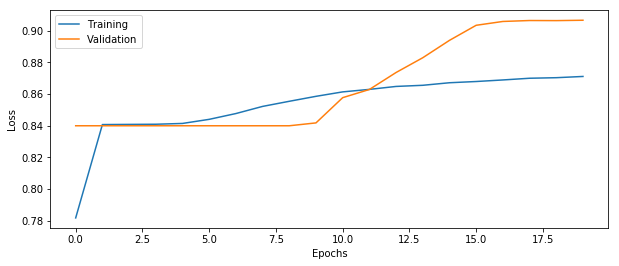

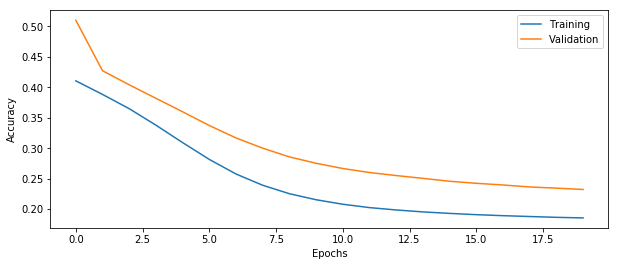

In [45]:
plot_results(history9)

# Part 20: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 21: How high classification accuracy can you achieve for the test data? What is your best configuration?

Answer 21: Setting batch_size=10000, epochs=30, n_layers=5, n_nodes=20, optimizer='adam', learning_rate=0.01, act_fun='sigmoid', no batch normalization and no dropout, we have achieved a test accuracy of 0.94

In [46]:
# Find your best configuration for the DNN
batch_size = 10000
epochs = 30
input_shape = (92,)

# Build and train DNN
model10 = build_DNN(input_shape=input_shape, n_layers=5, n_nodes=20, optimizer='adam', learning_rate=0.01)

history10 = model10.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/30
 - 1s - loss: 0.4123 - accuracy: 0.8408 - val_loss: 0.2717 - val_accuracy: 0.8400
Epoch 2/30
 - 1s - loss: 0.1982 - accuracy: 0.8877 - val_loss: 0.1680 - val_accuracy: 0.9107
Epoch 3/30
 - 1s - loss: 0.1612 - accuracy: 0.9154 - val_loss: 0.1587 - val_accuracy: 0.9172
Epoch 4/30
 - 1s - loss: 0.1567 - accuracy: 0.9181 - val_loss: 0.1558 - val_accuracy: 0.9193
Epoch 5/30
 - 1s - loss: 0.1542 - accuracy: 0.9195 - val_loss: 0.1533 - val_accuracy: 0.9199
Epoch 6/30
 - 1s - loss: 0.1508 - accuracy: 0.9207 - val_loss: 0.1485 - val_accuracy: 0.9212
Epoch 7/30
 - 1s - loss: 0.1461 - accuracy: 0.9216 - val_loss: 0.1449 - val_accuracy: 0.9218
Epoch 8/30
 - 1s - loss: 0.1418 - accuracy: 0.9238 - val_loss: 0.1409 - val_accuracy: 0.9238
Epoch 9/30
 - 1s - loss: 0.1371 - accuracy: 0.9271 - val_loss: 0.1363 - val_accuracy: 0.9272
Epoch 10/30
 - 1s - loss: 0.1327 - accuracy: 0.9293 - val_loss: 0.1329 - val_accuracy: 0.9295
Epoch 11/30
 - 1s

In [47]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest, batch_size=batch_size)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test loss: 0.1162
Test accuracy: 0.9382


# Part 21: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 22: What is the mean and the standard deviation of the test accuracy?

Answer 22: Answer in last code chunk of Part 21

In [48]:
import keras
import keras.backend as K

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [49]:
# Your best training parameters
batch_size = 10000
epochs = 30
input_shape = (92,)

# Build and train model
model11 = build_DNN(input_shape=input_shape, n_layers=5, n_nodes=20, optimizer='adam', 
                   learning_rate=0.01, use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, 
                      class_weight=class_weights, validation_data=(Xval, Yval))

Train on 534895 samples, validate on 114621 samples
Epoch 1/30
 - 1s - loss: 0.4862 - accuracy: 0.8170 - val_loss: 0.4238 - val_accuracy: 0.8394
Epoch 2/30
 - 1s - loss: 0.2975 - accuracy: 0.8578 - val_loss: 0.2151 - val_accuracy: 0.8855
Epoch 3/30
 - 1s - loss: 0.1959 - accuracy: 0.8943 - val_loss: 0.1837 - val_accuracy: 0.9021
Epoch 4/30
 - 1s - loss: 0.1802 - accuracy: 0.9037 - val_loss: 0.1775 - val_accuracy: 0.9049
Epoch 5/30
 - 1s - loss: 0.1752 - accuracy: 0.9070 - val_loss: 0.1740 - val_accuracy: 0.9082
Epoch 6/30
 - 1s - loss: 0.1727 - accuracy: 0.9082 - val_loss: 0.1723 - val_accuracy: 0.9086
Epoch 7/30
 - 1s - loss: 0.1714 - accuracy: 0.9090 - val_loss: 0.1710 - val_accuracy: 0.9087
Epoch 8/30
 - 1s - loss: 0.1700 - accuracy: 0.9101 - val_loss: 0.1700 - val_accuracy: 0.9105
Epoch 9/30
 - 1s - loss: 0.1688 - accuracy: 0.9111 - val_loss: 0.1680 - val_accuracy: 0.9115
Epoch 10/30
 - 1s - loss: 0.1684 - accuracy: 0.9113 - val_loss: 0.1675 - val_accuracy: 0.9119
Epoch 11/30
 - 1s

In [50]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest, batch_size=batch_size)
                       
print('Test accuracy: %.4f' % score[1])

114621/114621 [==============================] - 0s 1us/step
Test accuracy: 0.9154


In [51]:
%%capture
# Run the testing 100 times, and save the accuracies in an array
accuracies=[]
for i in range(100):
    score = model11.evaluate(Xtest, Ytest, batch_size=batch_size)
    accuracies.append(score[1])

In [52]:
# Calculate and print mean and std of accuracies
print('Mean of 100 accuracies: {}'.format(np.mean(accuracies)))
print('Std of 100 accuracies: {}'.format(np.std(accuracies)))

Mean of 100 accuracies: 0.9151230573654174
Std of 100 accuracies: 0.00020146933190101347


# Part 22: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 23: What is the mean and the standard deviation of the test accuracy?

Answer 23: Answer in last code chunk of Part 22

Question 24: What is the main advantage of dropout compared to CV for estimating test uncertainty?

Answer 24: Dropout method is less computationally expensive than CV. In CV we split the data in kfolds,train the model on k-1 folds and evaluate using the fold left and this is computationally expensive especially when we have large number of data. On the other hand, dropout method drops-out randomly some nodes with a given probability during each iteration(one forward + one backward pass).

In [53]:
from sklearn.model_selection import StratifiedKFold

batch_size = 10000
epochs = 30
input_shape = (92,)
accuracies_cv=[]

# Define 10-fold cross validation
cv_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

# Loop over cross validation folds
for train, test in cv_folds.split(X, Y):
    Xtrain, Xtest = X[train], X[test]
    Ytrain, Ytest = Y[train], Y[test]
    
    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight('balanced', np.unique(Ytrain), Ytrain)
    
    # Rebuild the DNN model, to not continue training on the previously trained model
    model12 = build_DNN(input_shape=input_shape, n_layers=5, n_nodes=20, optimizer='adam', 
                   learning_rate=0.01, use_custom_dropout=True)
    
    # Fit the model with training set and class weights for this fold
    history12 = model12.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=0, 
                      class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model12.evaluate(Xtest, Ytest, batch_size=batch_size)
    
    # Save the test accuracy in an array
    accuracies_cv.append(score[1])

76413/76413 [==============================] - 0s 1us/step


In [54]:
# Calculate and print mean and std of accuracies
print('Mean of cv accuracies: {}'.format(np.mean(accuracies_cv)))
print('Std of cv accuracies: {}'.format(np.std(accuracies_cv)))

Mean of cv accuracies: 0.9151513397693634
Std of cv accuracies: 0.001209783803942185


# Part 23: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 25: How would you change the DNN in order to use it for regression instead?

Answer 25: Classification is for categorigal data whereas regression is for continuous.
To perform regression for a similar DNN,we would choose another loss function for the regression, for example 'mean_squared_error'. After building the model as previously we would then use KerasRegressor function with parameters the model built, the number of epochs and the batch size and this is the estimator. For the final output layer, we do not need to define an activation function, since we have a regression problem. Finally we would evaluate the model using cv for example.


## Report

Send in this jupyter notebook, with answers to all questions.